In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from openeye import oechem
import json
from fragmenter import workflow_api, fragment, torsions, chemi
import cmiles
import oenotebook as oenb

In [2]:
with open('../../combinatorial_fragmentation/filter/filtered_kinase_inhibitors.json', 'r') as f:
    kinase_inhibitors = json.load(f)


In [3]:
frags = {}
for ki in kinase_inhibitors:
    with open('{}/{}_frags_to_drive_2.json'.format(ki, ki), 'r') as f:
        ki_frags = json.load(f)

    for bond in ki_frags:
        b = bond.split('[')[-1].split(']')[0].split(',')
        b = (int(b[0]), int(b[1]))
        for frag_type in ki_frags[bond]:
            for frag, wbo in ki_frags[bond][frag_type]:
                try:
                    mol_ids = cmiles.get_molecule_ids(frag, strict=False)
                except:
                    mol = oechem.OEMol()
                    oechem.OESmilesToMol(mol, frag)
                    mols = fragment._expand_states(mol, enumerate='stereoisomers')
                    mol_ids = []
                    for m in mols:
                        stereo_smiles = oechem.OEMolToSmiles(m)
                        mol_ids.append(cmiles.get_molecule_ids(stereo_smiles, strict=False))
                if not isinstance(mol_ids, list):
                    mol_ids = [mol_ids]
                    
                for mol_id in mol_ids:
                    smiles = mol_id['canonical_isomeric_smiles']
                    if smiles not in frags:
                        frags[smiles] = {'identifiers': mol_id}
                        frags[smiles]['provenance'] = {}
                        frags[smiles]['provenance']['canonicalization'] = mol_id.pop('provenance')
                        frags[smiles]['provenance']['parent_molecule'] = ki
                        frags[smiles]['provenance']['central_rot_bond'] = []
                        frags[smiles]['provenance']['map_to_parent'] = []
                        frags[smiles]['provenance']['wbo'] = []
                    frags[smiles]['provenance']['central_rot_bond'].append(b)
                    frags[smiles]['provenance']['map_to_parent'].append(frag)
                    frags[smiles]['provenance']['wbo'].append(wbo)



/Users/sternc1/anaconda3/envs/qcf/lib/python3.7/site-packages/cmiles-0.1.5-py3.7.egg/cmiles/_cmiles_oe.py:405: UserWarning: Stereochemistry is unspecified. Problematic atoms [(3, 'N')], problematic bonds [], SMILES: C#CCN1CCC[C@H]1c2nc(c3n2ccnc3N)c4ccc(cc4)C(=O)N
/Users/sternc1/anaconda3/envs/qcf/lib/python3.7/site-packages/cmiles-0.1.5-py3.7.egg/cmiles/_cmiles_oe.py:405: UserWarning: Stereochemistry is unspecified. Problematic atoms [(3, 'N')], problematic bonds [], SMILES: C#CCN1CCC[C@H]1c2nc(c3n2ccnc3N)c4ccc(cc4)C(=O)Nc5ccccn5
/Users/sternc1/anaconda3/envs/qcf/lib/python3.7/site-packages/cmiles-0.1.5-py3.7.egg/cmiles/_cmiles_oe.py:405: UserWarning: Stereochemistry is unspecified. Problematic atoms [(30, 'N')], problematic bonds [], SMILES: C#CCN1CCC[C@H]1c2nc(c3n2ccnc3N)c4ccc(cc4)C(=O)Nc5ccccn5
/Users/sternc1/anaconda3/envs/qcf/lib/python3.7/site-packages/cmiles-0.1.5-py3.7.egg/cmiles/_cmiles_oe.py:405: UserWarning: Stereochemistry is unspecified. Problematic atoms [(1, 'C')], probl

/Users/sternc1/anaconda3/envs/qcf/lib/python3.7/site-packages/cmiles-0.1.5-py3.7.egg/cmiles/_cmiles_oe.py:405: UserWarning: Stereochemistry is unspecified. Problematic atoms [(20, 'N')], problematic bonds [], SMILES: c1cc(ncc1N2CCNCC2)Nc3ncc4c(n3)N(CC=C4)C5CCCC5
/Users/sternc1/anaconda3/envs/qcf/lib/python3.7/site-packages/cmiles-0.1.5-py3.7.egg/cmiles/_cmiles_oe.py:405: UserWarning: Stereochemistry is unspecified. Problematic atoms [(20, 'N')], problematic bonds [], SMILES: CC1=CCN(c2c1cnc(n2)Nc3ccc(cn3)N4CCNCC4)C5CCCC5
/Users/sternc1/anaconda3/envs/qcf/lib/python3.7/site-packages/cmiles-0.1.5-py3.7.egg/cmiles/_cmiles_oe.py:405: UserWarning: Stereochemistry is unspecified. Problematic atoms [(14, 'N')], problematic bonds [], SMILES: c1ccnc(c1)Nc2ncc3c(n2)N(CC=C3)C4CCCC4
/Users/sternc1/anaconda3/envs/qcf/lib/python3.7/site-packages/cmiles-0.1.5-py3.7.egg/cmiles/_cmiles_oe.py:405: UserWarning: Stereochemistry is unspecified. Problematic atoms [(19, 'N')], problematic bonds [], SMILES: c

In [4]:
# Save all jobs
with open('all_frags_to_drive.json', 'w') as f:
    json.dump(frags, f, indent=2, sort_keys=True)

In [5]:
filtered_frags = {}

for ki in kinase_inhibitors:
    print(ki)
    with open('{}/{}_frags_to_drive_2.json'.format(ki, ki), 'r') as f:
        ki_frags = json.load(f)
    bonds_to_run = []
    for bond in ki_frags:
        wbos = []
        for frag_type in ki_frags[bond]:
            for frag, wbo in ki_frags[bond][frag_type]:
                wbos.append(wbo)
        sorted_wbo = sorted(wbos)
        diff = sorted_wbo[-1] - sorted_wbo[0]
        if diff > 0.09:
            bonds_to_run.append(bond)


    for bond in bonds_to_run:
        print(bond)
        b = bond.split('[')[-1].split(']')[0].split(',')
        b = (int(b[0]), int(b[1]))
        for frag_type in ki_frags[bond]:
            for frag, wbo in ki_frags[bond][frag_type]:
                try:
                    mol_ids = cmiles.get_molecule_ids(frag, strict=False)
                except:
                    mol = oechem.OEMol()
                    oechem.OESmilesToMol(mol, frag)
                    mols = fragment._expand_states(mol, enumerate='stereoisomers')
                    mol_ids = []
                    for m in mols:
                        stereo_smiles = oechem.OEMolToSmiles(m)
                        mol_ids.append(cmiles.get_molecule_ids(stereo_smiles, strict=False))
                if not isinstance(mol_ids, list):
                    mol_ids = [mol_ids]
                    
                for mol_id in mol_ids:
                    smiles = mol_id['canonical_isomeric_smiles']
                    if smiles not in filtered_frags:
                        filtered_frags[smiles] = {'identifiers': mol_id}
                        filtered_frags[smiles]['provenance'] = {}
                        filtered_frags[smiles]['provenance']['canonicalization'] = mol_id.pop('provenance')
                        filtered_frags[smiles]['provenance']['parent_molecule'] = ki
                        filtered_frags[smiles]['provenance']['central_rot_bond'] = []
                        filtered_frags[smiles]['provenance']['map_to_parent'] = []
                        filtered_frags[smiles]['provenance']['wbo'] = []
                    filtered_frags[smiles]['provenance']['central_rot_bond'].append(b)
                    filtered_frags[smiles]['provenance']['map_to_parent'].append(frag)
                    filtered_frags[smiles]['provenance']['wbo'].append(wbo)

# Save filtered jobs
with open('filtered_frags_to_drive.json', 'w') as f:
    json.dump(filtered_frags, f, indent=2, sort_keys=True)

Abemaciclib
Acalabrutinib
Axitinib
Baricitinib
Binimetinib
Brigatinib
[15, 35]
Cobimetinib
[8, 24]
Crizotinib
Dabrafenib
Dacomitinib
[14, 28]
Dasatinib
Gefitinib
[14, 26]
Ibrutinib
Idelalisib
[17, 29]
Imatinib
Larotrectinib
Lenvatinib
Nilotinib
Palbociclib
Pazopanib
Ponatinib
Ribociclib
[11, 30]
Ruxolitinib
Sunitinib
Tofacitinib
[7, 22]
Trametinib
[16, 30]
Vemurafenib


In [6]:
def get_torsion(mol, rot_bond):
    tors = [[tor.a, tor.b, tor.c, tor.d] for tor in oechem.OEGetTorsions(mol)]
    filtered_torsions = torsions.one_torsion_per_rotatable_bond(tors)
    mapped_tors = [[i.GetMapIdx() for i in t] for t in filtered_torsions]
    cbs = [(t[1], t[2]) for t in mapped_tors]
    try:
        dihedral = mapped_tors[cbs.index(rot_bond)]
    except ValueError:
        dihedral = mapped_tors[cbs.index(tuple(reversed(rot_bond)))]
    dihedral = [d-1 for d in dihedral]
    return dihedral



In [7]:
torsiondrive_jobs = {}
keep_track = {}
for frag in filtered_frags:
    can_smiles = filtered_frags[frag]['identifiers']['canonical_isomeric_explicit_hydrogen_mapped_smiles']
    for i, bond in enumerate(filtered_frags[frag]['provenance']['central_rot_bond']):
        map_to_parent = filtered_frags[frag]['provenance']['map_to_parent'][i]
        map_to_parent_mol = oechem.OEMol()
        oechem.OESmilesToMol(map_to_parent_mol, map_to_parent)
        dihedral_in_parent = get_torsion(map_to_parent_mol, bond)
        job_label = cmiles.utils.to_canonical_label(mapped_smiles=map_to_parent, labeled_atoms=dihedral_in_parent)
        if job_label not in keep_track:
            keep_track[job_label] = [{'parent_molecule': filtered_frags[frag]['provenance']['parent_molecule'],
                                'central_bond': filtered_frags[frag]['provenance']['central_rot_bond'][i],
                                'map_to_parent': filtered_frags[frag]['provenance']['map_to_parent'][i]}]
        else:
            keep_track[job_label].append({'parent_molecule': filtered_frags[frag]['provenance']['parent_molecule'],
                                'central_bond': filtered_frags[frag]['provenance']['central_rot_bond'][i],
                                'map_to_parent': filtered_frags[frag]['provenance']['map_to_parent'][i]})
            
        if job_label in torsiondrive_jobs:
            continue
        # Map dihedral onto new atom map
        # Add explicit hydrogen
        oechem.OEAddExplicitHydrogens(map_to_parent_mol)
        cmiles._cmiles_oe.canonical_order_atoms(map_to_parent_mol)
        map_to_parent = cmiles.utils.get_atom_map(map_to_parent_mol, map_to_parent)
        dih = [map_to_parent[d+1] for d in dihedral_in_parent]
        
        # Generate starting conformations. First add hydrogens
        oechem.OEAddExplicitHydrogens(map_to_parent_mol)
        conformers = chemi.generate_conformers(map_to_parent_mol, strict_types=False, max_confs=10)
        # Genereate QCSchema molecules
        qcschema_mols = [cmiles.utils.mol_to_map_ordered_qcschema(conf, can_smiles) for conf in conformers.GetConfs()]
        
        torsiondrive_jobs[job_label] = {'initial_molecule': qcschema_mols, 'dihedral': [dih], 'grid': [15],
              'identifiers': filtered_frags[frag]['identifiers'],  'provenance': 
                                        {'canonicalization': filtered_frags[frag]['provenance']['canonicalization']}}
        

19:49:40 INFO fragmenter: List of torsion to drive:
19:49:40 INFO fragmenter: Idx: 15 35 11 13
19:49:40 INFO fragmenter: Atom numbers: 6 7 6 6
19:49:40 INFO fragmenter: Idx: 11 35 15 31
19:49:40 INFO fragmenter: Atom numbers: 6 7 6 7
19:49:41 INFO fragmenter: List of torsion to drive:
19:49:41 INFO fragmenter: Idx: 15 35 11 13
19:49:41 INFO fragmenter: Atom numbers: 6 7 6 6
19:49:41 INFO fragmenter: Idx: 11 35 15 31
19:49:41 INFO fragmenter: Atom numbers: 6 7 6 7
19:49:41 INFO fragmenter: List of torsion to drive:
19:49:41 INFO fragmenter: Idx: 15 35 11 13
19:49:41 INFO fragmenter: Atom numbers: 6 7 6 6
19:49:41 INFO fragmenter: Idx: 11 35 15 31
19:49:41 INFO fragmenter: Atom numbers: 6 7 6 7
19:49:41 INFO fragmenter: List of torsion to drive:
19:49:41 INFO fragmenter: Idx: 15 35 11 13
19:49:41 INFO fragmenter: Atom numbers: 6 7 6 6
19:49:41 INFO fragmenter: Idx: 11 35 15 31
19:49:41 INFO fragmenter: Atom numbers: 6 7 6 7
19:49:41 INFO fragmenter: List of torsion to drive:
19:49:41 INF

19:49:47 INFO fragmenter: Atom numbers: 6 6 7 6
19:49:48 INFO fragmenter: List of torsion to drive:
19:49:48 INFO fragmenter: Idx: 8 24 7 10
19:49:48 INFO fragmenter: Atom numbers: 6 7 6 6
19:49:48 INFO fragmenter: Idx: 7 24 8 11
19:49:48 INFO fragmenter: Atom numbers: 6 7 6 6
19:49:48 INFO fragmenter: Idx: 8 6 13 25
19:49:48 INFO fragmenter: Atom numbers: 6 6 6 8
19:49:48 INFO fragmenter: List of torsion to drive:
19:49:48 INFO fragmenter: Idx: 8 24 7 10
19:49:48 INFO fragmenter: Atom numbers: 6 7 6 6
19:49:48 INFO fragmenter: Idx: 7 24 8 11
19:49:48 INFO fragmenter: Atom numbers: 6 7 6 6
19:49:48 INFO fragmenter: Idx: 8 6 13 25
19:49:48 INFO fragmenter: Atom numbers: 6 6 6 8
19:49:48 INFO fragmenter: List of torsion to drive:
19:49:48 INFO fragmenter: Idx: 8 24 7 10
19:49:48 INFO fragmenter: Atom numbers: 6 7 6 6
19:49:48 INFO fragmenter: Idx: 7 24 8 11
19:49:48 INFO fragmenter: Atom numbers: 6 7 6 6
19:49:48 INFO fragmenter: Idx: 8 6 13 25
19:49:48 INFO fragmenter: Atom numbers: 6 6

19:49:51 INFO fragmenter: Idx: 9 28 14 26
19:49:51 INFO fragmenter: Atom numbers: 6 7 6 7
19:49:51 INFO fragmenter: Idx: 10 11 31 23
19:49:51 INFO fragmenter: Atom numbers: 6 6 8 6
19:49:51 INFO fragmenter: Idx: 3 10 29 17
19:49:51 INFO fragmenter: Atom numbers: 6 6 7 6
19:49:51 INFO fragmenter: Idx: 10 29 17 30
19:49:51 INFO fragmenter: Atom numbers: 6 7 6 8
19:49:51 INFO fragmenter: List of torsion to drive:
19:49:51 INFO fragmenter: Idx: 14 28 9 5
19:49:51 INFO fragmenter: Atom numbers: 6 7 6 6
19:49:51 INFO fragmenter: Idx: 9 28 14 26
19:49:51 INFO fragmenter: Atom numbers: 6 7 6 7
19:49:51 INFO fragmenter: Idx: 10 11 31 23
19:49:51 INFO fragmenter: Atom numbers: 6 6 8 6
19:49:51 INFO fragmenter: Idx: 3 10 29 17
19:49:51 INFO fragmenter: Atom numbers: 6 6 7 6
19:49:51 INFO fragmenter: Idx: 10 29 17 30
19:49:51 INFO fragmenter: Atom numbers: 6 7 6 8
19:49:51 INFO fragmenter: List of torsion to drive:
19:49:51 INFO fragmenter: Idx: 14 28 9 5
19:49:51 INFO fragmenter: Atom numbers: 6 

19:49:53 INFO fragmenter: Atom numbers: 6 7 6 7
19:49:53 INFO fragmenter: Idx: 10 11 28 19
19:49:53 INFO fragmenter: Atom numbers: 6 6 8 6
19:49:53 INFO fragmenter: Idx: 3 10 29 22
19:49:53 INFO fragmenter: Atom numbers: 6 6 8 6
19:49:53 INFO fragmenter: List of torsion to drive:
19:49:53 INFO fragmenter: Idx: 14 26 9 5
19:49:53 INFO fragmenter: Atom numbers: 6 7 6 6
19:49:53 INFO fragmenter: Idx: 9 26 14 24
19:49:53 INFO fragmenter: Atom numbers: 6 7 6 7
19:49:53 INFO fragmenter: Idx: 10 11 28 19
19:49:53 INFO fragmenter: Atom numbers: 6 6 8 6
19:49:53 INFO fragmenter: Idx: 3 10 29 22
19:49:53 INFO fragmenter: Atom numbers: 6 6 8 6
19:49:53 INFO fragmenter: Idx: 10 29 22 20
19:49:53 INFO fragmenter: Atom numbers: 6 8 6 6
19:49:53 INFO fragmenter: List of torsion to drive:
19:49:53 INFO fragmenter: Idx: 14 26 9 5
19:49:53 INFO fragmenter: Atom numbers: 6 7 6 6
19:49:53 INFO fragmenter: Idx: 9 26 14 24
19:49:53 INFO fragmenter: Atom numbers: 6 7 6 7
19:49:53 INFO fragmenter: Idx: 10 11 

19:49:56 INFO fragmenter: Atom numbers: 7 6 6 6
19:49:56 INFO fragmenter: Idx: 29 22 19 26
19:49:56 INFO fragmenter: Atom numbers: 7 6 6 7
19:49:56 INFO fragmenter: List of torsion to drive:
19:49:56 INFO fragmenter: Idx: 22 29 17 24
19:49:56 INFO fragmenter: Atom numbers: 6 7 6 7
19:49:56 INFO fragmenter: Idx: 17 29 22 21
19:49:56 INFO fragmenter: Atom numbers: 6 7 6 6
19:49:56 INFO fragmenter: Idx: 29 22 21 20
19:49:56 INFO fragmenter: Atom numbers: 7 6 6 6
19:49:56 INFO fragmenter: Idx: 29 22 19 28
19:49:56 INFO fragmenter: Atom numbers: 7 6 6 7
19:49:56 INFO fragmenter: Idx: 18 28 14 6
19:49:56 INFO fragmenter: Atom numbers: 6 7 6 6
19:49:56 INFO fragmenter: List of torsion to drive:
19:49:56 INFO fragmenter: Idx: 11 30 10 24
19:49:56 INFO fragmenter: Atom numbers: 6 7 6 7
19:49:56 INFO fragmenter: Idx: 10 30 11 26
19:49:56 INFO fragmenter: Atom numbers: 6 7 6 7
19:49:56 INFO fragmenter: List of torsion to drive:
19:49:56 INFO fragmenter: Idx: 11 30 10 24
19:49:56 INFO fragmenter: 

19:50:00 INFO fragmenter: List of torsion to drive:
19:50:00 INFO fragmenter: Idx: 11 13 22 15
19:50:00 INFO fragmenter: Atom numbers: 6 6 7 6
19:50:00 INFO fragmenter: Idx: 13 22 7 19
19:50:00 INFO fragmenter: Atom numbers: 6 7 6 7
19:50:00 INFO fragmenter: List of torsion to drive:
19:50:00 INFO fragmenter: Idx: 11 13 22 15
19:50:00 INFO fragmenter: Atom numbers: 6 6 7 6
19:50:00 INFO fragmenter: Idx: 13 22 7 19
19:50:00 INFO fragmenter: Atom numbers: 6 7 6 7
19:50:00 INFO fragmenter: List of torsion to drive:
19:50:00 INFO fragmenter: Idx: 11 13 22 15
19:50:00 INFO fragmenter: Atom numbers: 6 6 7 6
19:50:00 INFO fragmenter: Idx: 13 22 7 19
19:50:00 INFO fragmenter: Atom numbers: 6 7 6 7
19:50:00 INFO fragmenter: List of torsion to drive:
19:50:00 INFO fragmenter: Idx: 11 13 22 15
19:50:00 INFO fragmenter: Atom numbers: 6 6 7 6
19:50:00 INFO fragmenter: Idx: 13 22 7 19
19:50:00 INFO fragmenter: Atom numbers: 6 7 6 7
19:50:00 INFO fragmenter: List of torsion to drive:
19:50:00 INFO fr

19:50:01 INFO fragmenter: List of torsion to drive:
19:50:01 INFO fragmenter: Idx: 11 13 22 15
19:50:01 INFO fragmenter: Atom numbers: 6 6 7 6
19:50:01 INFO fragmenter: Idx: 13 22 7 19
19:50:01 INFO fragmenter: Atom numbers: 6 7 6 7
19:50:01 INFO fragmenter: Idx: 10 21 8 23
19:50:01 INFO fragmenter: Atom numbers: 6 7 6 8
19:50:01 INFO fragmenter: Idx: 23 8 16 1
19:50:01 INFO fragmenter: Atom numbers: 8 6 6 6
19:50:01 INFO fragmenter: List of torsion to drive:
19:50:01 INFO fragmenter: Idx: 11 13 22 15
19:50:01 INFO fragmenter: Atom numbers: 6 6 7 6
19:50:01 INFO fragmenter: Idx: 13 22 7 19
19:50:01 INFO fragmenter: Atom numbers: 6 7 6 7
19:50:01 INFO fragmenter: Idx: 10 21 8 23
19:50:01 INFO fragmenter: Atom numbers: 6 7 6 8
19:50:01 INFO fragmenter: Idx: 23 8 16 1
19:50:01 INFO fragmenter: Atom numbers: 8 6 6 6
19:50:01 INFO fragmenter: List of torsion to drive:
19:50:01 INFO fragmenter: Idx: 11 13 22 15
19:50:01 INFO fragmenter: Atom numbers: 6 6 7 6
19:50:01 INFO fragmenter: Idx: 13

19:50:02 INFO fragmenter: Atom numbers: 6 7 6 6
19:50:02 INFO fragmenter: Idx: 13 30 16 28
19:50:02 INFO fragmenter: Atom numbers: 6 7 6 7
19:50:02 INFO fragmenter: List of torsion to drive:
19:50:02 INFO fragmenter: Idx: 16 30 13 14
19:50:02 INFO fragmenter: Atom numbers: 6 7 6 6
19:50:02 INFO fragmenter: Idx: 13 30 16 28
19:50:02 INFO fragmenter: Atom numbers: 6 7 6 7
19:50:02 INFO fragmenter: Idx: 10 27 11 6
19:50:02 INFO fragmenter: Atom numbers: 6 7 6 6
19:50:03 INFO fragmenter: List of torsion to drive:
19:50:03 INFO fragmenter: Idx: 16 30 13 14
19:50:03 INFO fragmenter: Atom numbers: 6 7 6 6
19:50:03 INFO fragmenter: Idx: 13 30 16 28
19:50:03 INFO fragmenter: Atom numbers: 6 7 6 7
19:50:03 INFO fragmenter: Idx: 19 29 23 21
19:50:03 INFO fragmenter: Atom numbers: 6 7 6 6
19:50:03 INFO fragmenter: Idx: 10 27 11 6
19:50:03 INFO fragmenter: Atom numbers: 6 7 6 6
19:50:03 INFO fragmenter: List of torsion to drive:
19:50:03 INFO fragmenter: Idx: 16 30 13 14
19:50:03 INFO fragmenter: A

In [8]:
#Save inputs
with open('stability_benchmark_inputs.json', 'w') as f:
    json.dump(torsiondrive_jobs, f, indent=2, sort_keys=True)

In [9]:
confs = []
for j in torsiondrive_jobs:
    confs.append(len(torsiondrive_jobs[j]['initial_molecule']))

(array([ 2.,  5.,  4.,  9.,  0.,  4.,  4.,  3.,  3., 52.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

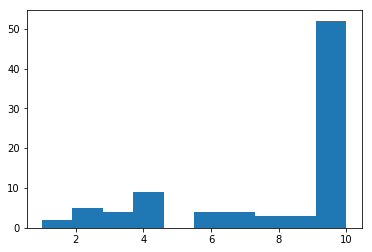

In [11]:
plt.hist(confs)